# Statuses total time
Sums the times instances spend in one of each states in the diagram saved as
"statuses.drawio". Unknown times are summed as "unknown"

In [1]:
import json
import sys
import pandas
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# QUEUE = set(["0-2", "1-2", "assumptions:", "1-1", "1-0"])
# RESUB = set(["4-1", "4-0", "5-1", "6-1", "7-1", "8-1", "assumptions:", "5-0", "6-0", "7-0", \
#   "8-0"])
# READY = set(["0-3", "2-3", "0-9", "2-9", "9-3", "2-7", "2-8", "9-7", "9-8", \
#   "9-9", "0-7", "0-8", "assumptions:", "2-0", "2-4", "9-4", "9-1"])
# RUN = set(["3-1", "3-10", "3-4", "3-5", "3-6", "3-7", "3-8", "10-5", "10-6", \
#   "10-7", "10-8", "10-4", "10-10", "10-1", "assumptions:", "3-0", "10-0", "3-3"])

QUEUE = set(["0-2", "1-2"])
ENDED = set(["5-1", "6-1", "7-1", "8-1"])
READY = set(["0-3", "0-9", "2-3", "2-9", "9-3", "9-9"])
RUN = set(["3-1", "3-4", "3-5", "3-6", "3-7", "3-8", "3-10", "10-1", "10-4", "10-5", "10-6", "10-7", "10-8", "10-10"])
EVICT = set(["4-1", "4-0"])

In [3]:
obj = {}

filename="/home/claudio/google_2019/thesis_queries/machine_time_waste/a_state_changes.json"

with open(filename, 'r') as f:
    obj = json.loads(f.read())

In [4]:
data = {'Last termination': [], 'time_type': [], 'time_ms': []}
totals = {}

def to_name(et):
    if et == 4: 
        return 'EVICT'
    elif et == 5: 
        return 'FAIL'
    elif et == 6:
        return 'FINISH'
    elif et == 7:
        return 'KILL'
    elif et == 8:
        return 'LOST'
    else:
        return 'NO_TERM'

def add_record(et, tt, time):
    data['Last termination'].append(to_name(et))
    data['time_type'].append(tt)
    data['time_ms'].append(time)
    
    
for pair in obj["data"]:
    s = set()
    qt = et = rt = xt = vt = ut = 0
  
    # print("End type " + str(pair[0]))  
    
    pair[0] = 0 if pair[0] is None else pair[0]
  
    x = pair[1]
    for k in x.keys():
        if k in QUEUE:
            qt += x[k]
        elif k in ENDED:
            et += x[k]
        elif k in READY:
            rt += x[k]
        elif k in RUN:
            xt += x[k]
        elif k in EVICT:
            vt += x[k]
        else:
            s.add(k)
            ut += x[k]
    
    add_record(pair[0], 'queued', qt)
    add_record(pair[0], 'ended', et)
    add_record(pair[0], 'ready', rt)
    add_record(pair[0], 'running', xt)
    add_record(pair[0], 'evicted', vt)
    add_record(pair[0], 'unknown', ut)
    totals[pair[0]] = qt + et + rt + xt + vt + ut
    # print(s) 
    
df = pandas.DataFrame(data, columns=['Last termination', 'time_type', 'time_ms'])

## Graph 1: Absolute total time spent per status per "last termination" type

   Last termination time_type       time_ms
0           NO_TERM    queued  1.515995e-02
1           NO_TERM     ended  0.000000e+00
2           NO_TERM     ready  3.365563e-02
3           NO_TERM   running  9.511017e-01
4           NO_TERM   evicted  0.000000e+00
5           NO_TERM   unknown  8.273546e-05
6             EVICT    queued  2.199883e-02
7             EVICT     ended  7.361000e-08
8             EVICT     ready  6.672357e-03
9             EVICT   running  8.789100e-01
10            EVICT   evicted  1.503149e-05
11            EVICT   unknown  9.240368e-02
12             FAIL    queued  8.517812e-02
13             FAIL     ended  0.000000e+00
14             FAIL     ready  9.300481e-04
15             FAIL   running  6.596810e-01
16             FAIL   evicted  6.492666e-12
17             FAIL   unknown  2.542109e-01
18           FINISH    queued  3.237908e-01
19           FINISH     ended  1.907057e-07
20           FINISH     ready  2.215952e-02
21           FINISH   running  3

Text(0, 0.5, 'Total microseconds')

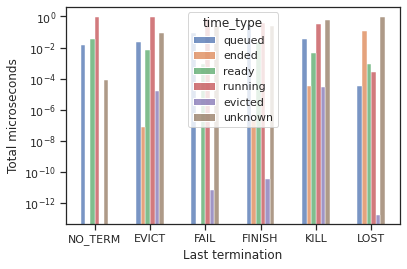

In [7]:
sns.set_theme(style="ticks")

print(df)

g = sns.histplot(df, x="Last termination", weights="time_ms", shrink=.5,
             hue="time_type", multiple="dodge", discrete=True)
g.set_yscale("log")
g.set_ylabel("Total microseconds") 

## Graph 2: Relative total time spent per status per "last termination" type

Values are proportions on total for each "last termination" type

/home/claudio/python-venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


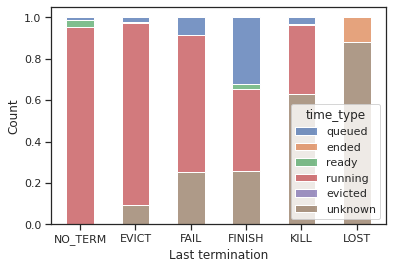

In [6]:
for i in [0,4,5,6,7,8]:
    df["time_ms"].loc[df["Last termination"] == to_name(i)] = df["time_ms"].loc[df["Last termination"] == to_name(i)] / totals[i]

h = sns.histplot(df, x="Last termination", weights="time_ms", shrink=.5, common_bins=True,
             hue="time_type", multiple="stack", discrete=True)